## 作業說明：
<div>
    <br>
    <img src="HW3_LSH_Document.png", width="650"/>
</div>

## Load Datasets

In [ ]:
import pandas as pd
data=pd.read_csv('/Users/leosu/Desktop/BD_HW3/instrument_clean.csv')

In [2]:
# 因為datasketch只能接受set的資料型態，所以用這個function把原本的資料轉換成set
def getSet(i):
    string = str(data.iloc[i]["reviews"])
    string_split = string.split()
    my_set = set(string_split)
    return my_set

## Implement MinHash

### 透過 datasketch 的 MinHash package，就可以在下面這個步驟完成到 step2 (MinHash)
<div>
    <br>
    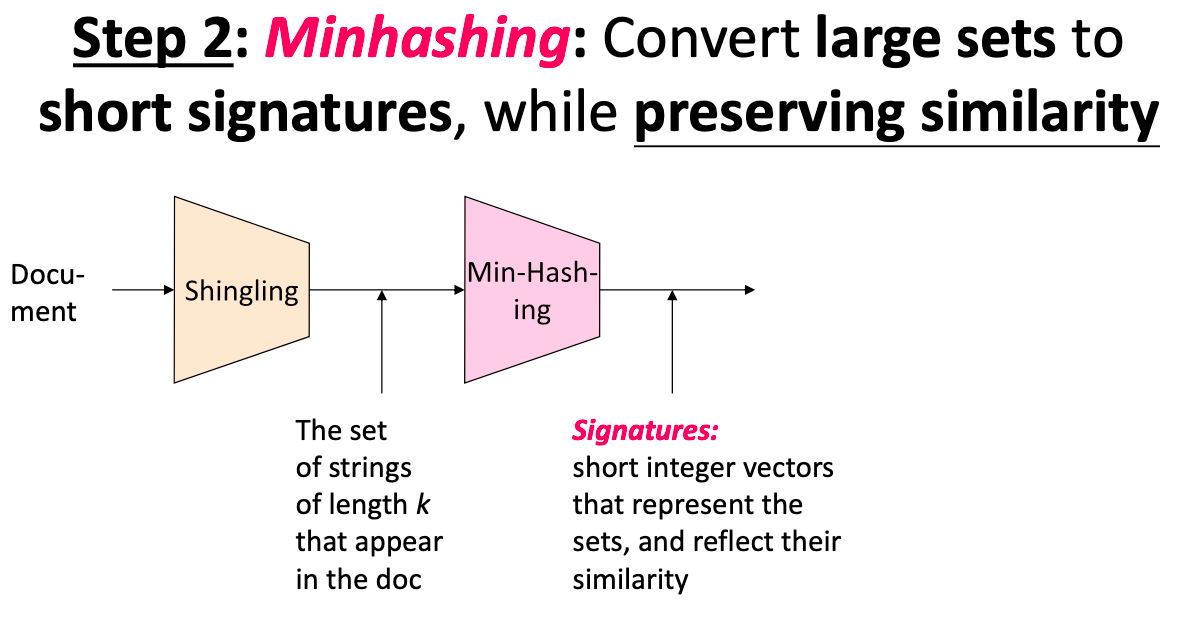
</div>

In [3]:
from datasketch import MinHash, MinHashLSH
import numpy as np
m = list()
for i in range(0,100000):
    m.append(MinHash(num_perm=128))
    for d in getSet(i):
        m[i].update(d.encode('utf8'))

## Implement KNN by Using Brute-Force Linear Search (denoted BFL)

In [136]:
def get_prediction_bf_cv1(k):
    default_rate = 5.0
    jaccard_list = []
    try:
        for i in range(20000,100000):
            jaccard_list.append(m[k].jaccard(m[i]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate

In [1]:
%%time
import time 
tStart = time.time() #計時開始
y_pred = []
BFL_time=[]
for i in range(0,20000):
    print("test" + str(i))
    y_pred.append(get_prediction_bf_cv1(i))
    tEnd = time.time()
    BFL_time.append(tEnd-tStart)

In [156]:
y_pred_df = pd.DataFrame(y_pred, columns=["rate"])

In [157]:
y_true = data.iloc[0:20000]["rate"]

In [158]:
from sklearn.metrics import accuracy_score
score_bf = accuracy_score(y_true, y_pred_df, normalize=True)

In [159]:
score_bf

0.48265

## Implement KNN by Using Locality-Sensitive Hashing Search (denoted LSH)

### 透過 datasketch 的 MinHashLSH package，就可以在下面這個步驟完成LSH
<div>
    <br>
    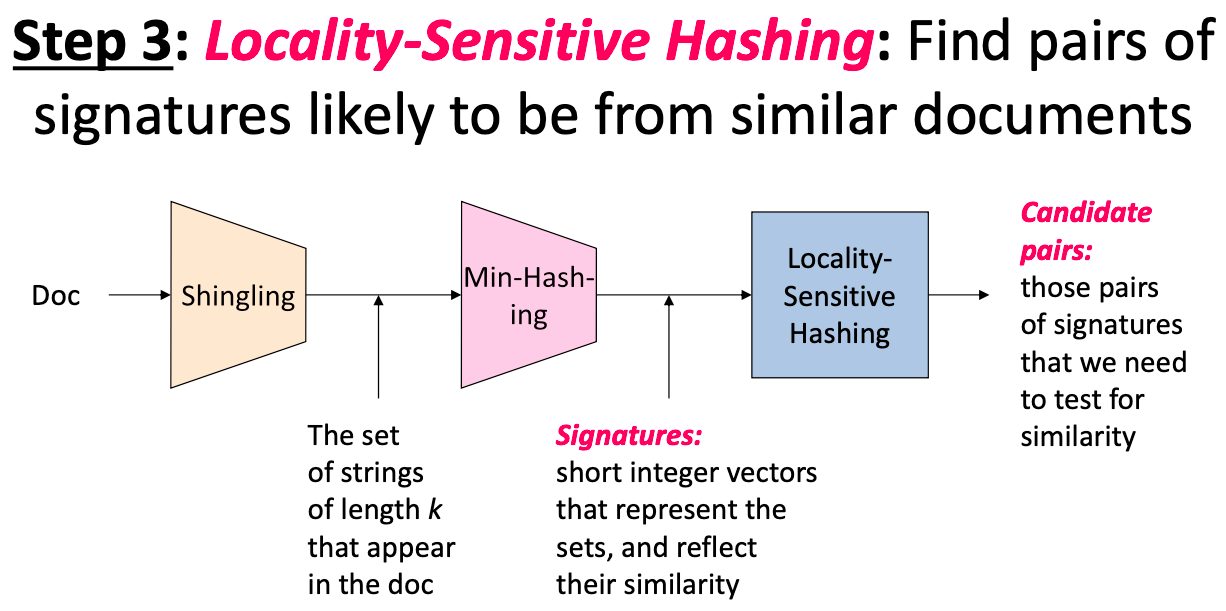
</div>

In [127]:
# Create LSH index
lsh = MinHashLSH(threshold=0.2, num_perm=128)
for i in range(20000,100000):
    lsh.insert(i, m[i])

In [128]:
# number of bands
lsh.h

128

In [129]:
def get_prediction(k):
    default_rate = 5.0
    result = lsh.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate
    
#     print(max_m)
#     print(data.iloc[max_m]["rate"])

In [2]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh = []
LSH_time=[]
for i in range(0,20000):
    y_pred_lsh.append(get_prediction(i))
    tEnd = time.time()
    LSH_time.append(tEnd-tStart)

In [131]:
y_pred_df_lsh = pd.DataFrame(y_pred_lsh, columns=["rate"])
y_true_lsh = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh = accuracy_score(y_true_lsh, y_pred_df_lsh, normalize=True)
score_lsh

0.4059

## Performance Comparison in Effectiveness and Efficiency

### Effectiveness

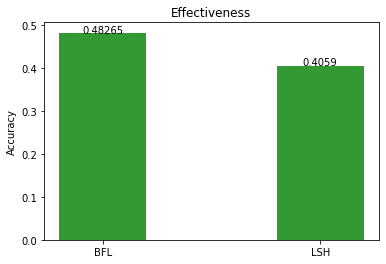

In [45]:
import matplotlib.pyplot as plt

effectiveness = [score_bf,score_lsh]

plt.bar(range(2), effectiveness, 0.4,color='g', alpha = 0.8,align='center')

plt.ylabel('Accuracy')
plt.title('Effectiveness')

plt.xticks(range(2),['BFL','LSH'])

for x,y in enumerate(effectiveness):
    plt.text(x,y,'%s' %y,ha='center')

plt.show()

### Efficency

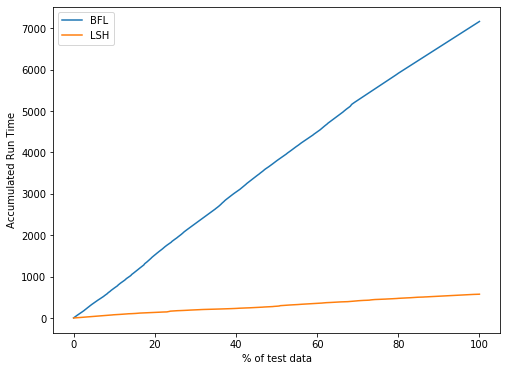

In [160]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(0,figsize=(8,6))

x = [x/len(BFL_time)*100 for x in range(len(BFL_time))]

line_BFL, = plt.plot(x, BFL_time, label='BFL')
line_LSH, = plt.plot(x, LSH_time, label='LSH')
plt.xlabel('% of test data')
plt.ylabel('Accumulated Run Time')
# plt.ylim([0,2])
plt.legend(handles=[line_BFL,line_LSH], loc=0)

plt.show()
plt.close()

在Effectiveness的表現上，很明顯的BFL的準確度較高，但BFL所要花的時間卻是LSH的好幾倍之多。

因為BFL是用最naive的方式一個一個比較，所以準確度通常來說會比較高，但是它卻要花上非常大量的時間成本，在資料量越來越大的現在，LSH勢必會是比較理想的作法，因為LSH大幅的降低了運算的時間，又可以達到還不錯的準確度。

## Change LSH Hyperparameters

### Change num_perm (number of permutation)

In [58]:
from datasketch import MinHash, MinHashLSH
import numpy as np
m_256_n = list()
for i in range(0,100000):
    m_256_n.append(MinHash(num_perm=256))
    for d in getSet(i):
        m_256_n[i].update(d.encode('utf8'))

In [59]:
# Create LSH index
#100 bands
lsh_256_n = MinHashLSH(threshold=0.2, num_perm=256)
#先把 0-19999 當test
for i in range(20000,100000):
    lsh_256_n.insert(i, m_256_n[i])


In [60]:
def get_prediction_256_n(k):
    default_rate = 5.0
    result = lsh_256_n.query(m_256_n[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m_256_n[k].jaccard(m_256_n[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate
    
#     print(max_m)
#     print(data.iloc[max_m]["rate"])

In [3]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_256_n = []
LSH_time_256_n=[]
for i in range(0,20000):
    y_pred_lsh_256_n.append(get_prediction_256_n(i))
    tEnd = time.time()
    LSH_time_256_n.append(tEnd-tStart)

In [67]:
y_pred_df_lsh_256_n = pd.DataFrame(y_pred_lsh_256_n, columns=["rate"])
y_true_lsh_256_n = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_256_n = accuracy_score(y_true_lsh_256_n, y_pred_df_lsh_256_n, normalize=True)
score_lsh_256_n

0.41515

#### Performance Comparison in Effectiveness and Efficiency

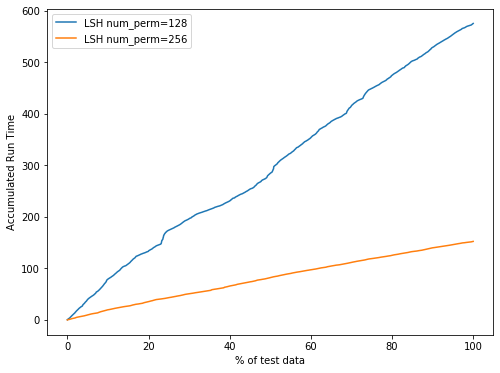

In [132]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(0,figsize=(8,6))

x = [x/len(LSH_time)*100 for x in range(len(LSH_time))]

# line_BFL, = plt.plot(x, BFL_time, label='BFL')
line_LSH, = plt.plot(x, LSH_time, label='LSH num_perm=128')
line_LSH_256_n, = plt.plot(x, LSH_time_256_n, label='LSH num_perm=256')

plt.xlabel('% of test data')
plt.ylabel('Accumulated Run Time')
# plt.ylim([0,2])
plt.legend(handles=[line_LSH,line_LSH_256_n], loc=0)

plt.show()
plt.close()

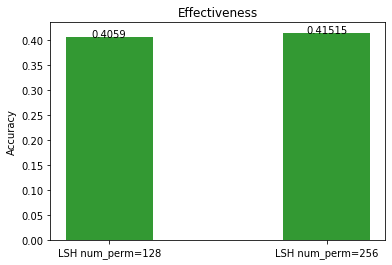

In [133]:
import matplotlib.pyplot as plt

effectiveness = [score_lsh,score_lsh_256_n]

plt.bar(range(2), effectiveness, 0.4,color='g', alpha = 0.8,align='center')

plt.ylabel('Accuracy')
plt.title('Effectiveness')

plt.xticks(range(2),['LSH num_perm=128','LSH num_perm=256'])

for x,y in enumerate(effectiveness):
    plt.text(x,y,'%s' %y,ha='center')

plt.show()

根據結果顯示，num_perm=256 時的效能為 0.41515，稍微勝過 num_perm=128 的 0.4059。不過因為 num_perm=256 時需要做更多的運算，因此在效率的表現上，num_perm=128 的速度明顯比 num_perm=256 快上許多。

### Change # of bands

#### 16 bands

In [147]:
# Create LSH index
#16 bands
lsh_16b = MinHashLSH(threshold=0.2, num_perm=128, params=(16,8))
for i in range(20000,100000):
    lsh_16b.insert(i, m[i])


In [148]:
# number of bands
lsh_16b.b

16

In [149]:
def get_prediction_16b(k):
    default_rate = 5.0
    result = lsh_16b.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
#         print(k, "value_error")
        return default_rate

In [150]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_16b = []
LSH_time_16b = []
for i in range(0,20000):
    y_pred_lsh_16b.append(get_prediction_16b(i))
    tEnd = time.time()
    LSH_time_16b.append(tEnd-tStart)

CPU times: user 4.87 s, sys: 2.38 s, total: 7.26 s
Wall time: 18.2 s


In [151]:
y_pred_df_lsh_16b = pd.DataFrame(y_pred_lsh_16b, columns=["rate"])
y_true_lsh_16b = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_16b = accuracy_score(y_true_lsh_16b, y_pred_df_lsh_16b, normalize=True)
score_lsh_16b

0.58925

In [152]:
y_pred_df_lsh_16b["rate"].value_counts()

5.0    18168
4.0     1831
3.0        1
Name: rate, dtype: int64

#### 32 bands

In [87]:
# Create LSH index
#32 bands
lsh_32b = MinHashLSH(threshold=0.2, num_perm=128, params=(32,4))
#先把 0-19999 當test
for i in range(20000,100000):
    lsh_32b.insert(i, m[i])


In [114]:
# number of bands
lsh_32b.b

32

In [88]:
def get_prediction_32b(k):
    default_rate = 5.0
    result = lsh_32b.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
#         print(k, "value_error")
        return default_rate

In [89]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_32b = []
LSH_time_32b = []
for i in range(0,20000):
    y_pred_lsh_32b.append(get_prediction_32b(i))
    tEnd = time.time()
    LSH_time_32b.append(tEnd-tStart)

CPU times: user 15.5 s, sys: 551 ms, total: 16.1 s
Wall time: 18 s


In [90]:
y_pred_df_lsh_32b = pd.DataFrame(y_pred_lsh_32b, columns=["rate"])
y_true_lsh_32b = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_32b = accuracy_score(y_true_lsh_32b, y_pred_df_lsh_32b, normalize=True)
score_lsh_32b

0.43115

In [91]:
y_pred_df_lsh_32b["rate"].value_counts()

5.0    11495
4.0     7833
3.0      552
2.0       78
1.0       42
Name: rate, dtype: int64

#### 64 bands

In [119]:
# Create LSH index
#64 bands
lsh_64b = MinHashLSH(threshold=0.2, num_perm=128, params=(64,2))
#先把 0-19999 當test
for i in range(20000,100000):
    lsh_64b.insert(i, m[i])


In [120]:
# number of bands
lsh_64b.b

64

In [121]:
def get_prediction_64b(k):
    default_rate = 5.0
    result = lsh_64b.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate

In [4]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_64b = []
LSH_time_64b = []
for i in range(0,20000):
    y_pred_lsh_64b.append(get_prediction_64b(i))
    tEnd = time.time()
    LSH_time_64b.append(tEnd-tStart)

In [123]:
y_pred_df_lsh_64b = pd.DataFrame(y_pred_lsh_64b, columns=["rate"])
y_true_lsh_64b = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_64b = accuracy_score(y_true_lsh_64b, y_pred_df_lsh_64b, normalize=True)
score_lsh_64b

0.4233

In [124]:
y_pred_df_lsh_64b["rate"].value_counts()

5.0    11832
4.0     3741
1.0     1954
3.0     1536
2.0      937
Name: rate, dtype: int64

#### Performance Comparison in Effectiveness and Efficiency

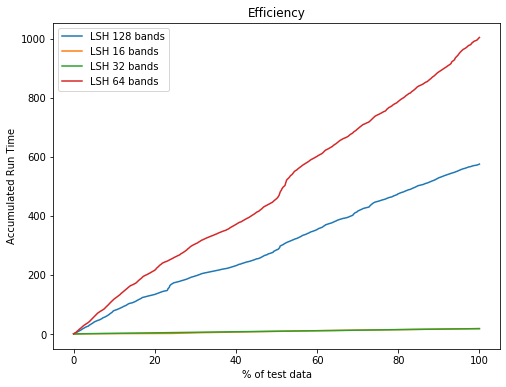

In [153]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(0,figsize=(8,6))

x = [x/len(LSH_time)*100 for x in range(len(LSH_time))]

# line_BFL, = plt.plot(x, BFL_time, label='BFL')
line_LSH, = plt.plot(x, LSH_time, label='LSH 128 bands')
line_LSH_16b, = plt.plot(x, LSH_time_16b, label='LSH 16 bands')
line_LSH_32b, = plt.plot(x, LSH_time_32b, label='LSH 32 bands')
line_LSH_64b, = plt.plot(x, LSH_time_64b, label='LSH 64 bands')

plt.title('Efficiency')
plt.xlabel('% of test data')
plt.ylabel('Accumulated Run Time')
# plt.ylim([0,2])
plt.legend(handles=[line_LSH,line_LSH_16b,line_LSH_32b,line_LSH_64b], loc=0)

plt.show()
plt.close()

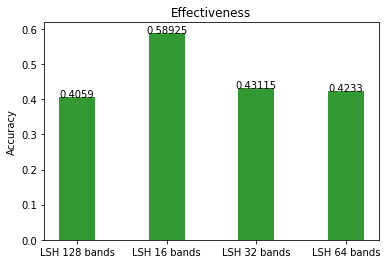

In [154]:
import matplotlib.pyplot as plt

effectiveness = [score_lsh,score_lsh_16b,score_lsh_32b,score_lsh_64b]

plt.bar(range(4), effectiveness, 0.4,color='g', alpha = 0.8,align='center')

plt.ylabel('Accuracy')
plt.title('Effectiveness')

plt.xticks(range(4),['LSH 128 bands','LSH 16 bands','LSH 32 bands','LSH 64 bands'])

for x,y in enumerate(effectiveness):
    plt.text(x,y,'%s' %y,ha='center')

plt.show()